Yesterday I tested the temporal instanton code on the 3120 node Polish grid (`case3120sp`). My entire computer hung, Chrome ran out of memory, bad things happened. My best guess: the system is just too big. Allocations are exceeding my system's memory, and stuff like garbage collecting is dominating the computation time.

To test this hypothesis, I will repeat yesterday's RTS-96 experiments using Julia 0.4 and the `spqr` option to see if total allocation is reduced.

In [1]:
# Analysis:
addprocs(2) # vary number of concurrent processes here
@everywhere include("../src/TemporalInstanton.jl")
@everywhere using TemporalInstanton

Ridx,Y,
Gp,Dp,Rp,
Sb,ref,lines,
res,reac,k,
line_lengths,line_conductors = load_rts96_data();

time_intervals = 6 # thirty minutes total
time_values = 0:30:300 # five minutes in 30-sec steps
int_length = 300. # seconds = 5 min
G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
D0 = [0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp]
P0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]

# Thermal model parameters:
Tamb = 35. # C
T0 = 60. #46. # initial line steady-state temp

60.0

In [8]:
#gc()
@time score,x,θ,α,diffs,xopt = solve_temporal_instanton(
    Ridx,Y,G0,P0,D0,Sb,ref,lines,
    res,reac,k,line_lengths,line_conductors,Tamb,
    T0,int_length);
println("Unsolved lines: $(sum(score.==Inf))")

   5.150 seconds      (33414 allocations: 19631 KB)
Unsolved lines: 0


** Julia 0.3, no spqr **
* 0 proc: 13.0 seconds,  5.3 GB
* 1 proc:  9.2 seconds, 30.0 MB
* 2 procs: 6.0 seconds, 43.6 MB
* 3 procs: 6.4 seconds, 56.2 MB
* 4 procs: 5.5 seconds, 68.9 MB
* 5 procs: 5.7 seconds, 81.6 MB
* 6 procs: 5.6 seconds, 94.3 MB

**Julia 0.4, spqr**
* 0 proc: 15.0 seconds,  4.1 GB`
* 1 proc:  7.7 seconds, 18.8 MB
* 2 procs: 4.8 seconds, 19.6 MB
* 3 procs: 5.8 seconds, 20.5 MB
* 4 procs: 4.8 seconds, 55.7 MB
* 5 procs: 4.9 seconds, 66.8 MB
* 6 procs: 5.1 seconds, 77.9 MB

In [33]:
using PyPlot
PyPlot.svg(true)

numProcs = [0:6][2:end]
calcTime3 = [13.0;9.2;6.0;6.4;5.5;5.7;5.6][2:end]
alloc3 = [5.3e9;30e6;43.6e6;56.2e6;68.9e6;81.6e6;94.3e6][2:end]

calcTime4 = [15.0;7.7;4.8;5.8;4.8;4.9;5.1][2:end]
alloc4 = [4.1e9;18.8e6;19.6e6;20.5e6;55.7e6;66.8e6;77.9e6][2:end]

6-element Array{Float64,1}:
 1.88e7
 1.96e7
 2.05e7
 5.57e7
 6.68e7
 7.79e7

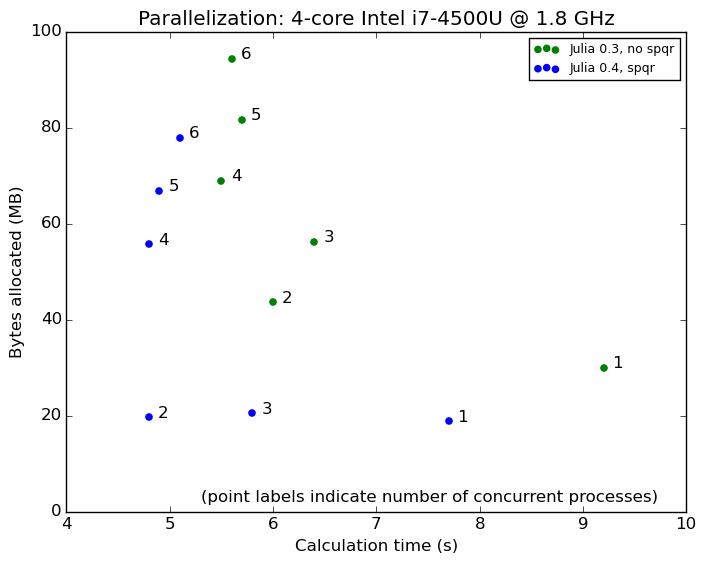

In [43]:
scatter(calcTime3,alloc3./1e6,color="g")
hold=true
scatter(calcTime4,alloc4./1e6,color="b")
legend(["Julia 0.3, no spqr","Julia 0.4, spqr"],fontsize=9)
#yscale("log")
#ylim(11^7,10.5^8)
xlabel("Calculation time (s)")
ylabel("Bytes allocated (MB)")
ylim([0,100])
for i in 1:length(alloc3)
    annotate(numProcs[i],(calcTime3[i]+0.1,alloc3[i]/1e6))
    annotate(numProcs[i],(calcTime4[i]+0.1,alloc4[i]/1e6))
end
annotate("(point labels indicate number of concurrent processes)",(5.3,2))
title("Parallelization: 4-core Intel i7-4500U @ 1.8 GHz")
# savefig("../images/2015-07-29-parallelization-performance.svg")

## Key takeaways

It is objectively better to use spqr with Julia 0.4. Regardless of the number of processors, 0.4 with spqr is always faster and requires less space.

For Julia 0.4, going from 2 processors to 4 doesn't speed things up very much, but it does result in a *tripling* of memory required. All that message-passing overhead isn't worth it -- I'm much better off using half the processing cores in my computer. I wonder if this holds for the 3120-node Polish grid?

I also wonder where most of the allocations are taking place. Is it possible to store the objective matrix as sparse and still perform all the manipulations I need? Time for some profiling.

## `analyze_malloc()`: search for "memory leaks"

I followed the instructions [here](https://github.com/IainNZ/Coverage.jl) to analyze allocation for my code. I used two procs and the RTS-96 6-time-step scenario. Here's the script I pasted into the REPL:

In [1]:
addprocs(2) # vary number of concurrent processes here
@everywhere include("../src/TemporalInstanton.jl")
@everywhere using TemporalInstanton

Ridx,Y,
Gp,Dp,Rp,
Sb,ref,lines,
res,reac,k,
line_lengths,line_conductors = load_rts96_data();

time_intervals = 6 # thirty minutes total
time_values = 0:30:300 # five minutes in 30-sec steps
int_length = 300. # seconds = 5 min
G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
D0 = [0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp]
P0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]

Tamb = 35. # C
T0 = 60. #46. # initial line steady-state temp

score,x,θ,α,diffs,xopt = solve_temporal_instanton(
    Ridx,Y,G0,P0,D0,Sb,ref,lines,
    res,reac,k,line_lengths,line_conductors,Tamb,
    T0,int_length);

60.0

Unsurprisingly, the biggest allocation offenders are the matrix building methods. Here are the top ten memory-hogging lines:

```julia
julia> alloc_data[end-9:end]
10-element Array{Coverage.MallocInfo,1}:
 (163072,"TemporalInstanton.jl",223)  
 (173824,"QCQPMatrixBuilding.jl",34)  
 (177808,"QCQPMatrixBuilding.jl",43)  
 (199840,"QCQPMatrixBuilding.jl",52)  
 (452608,"TemporalInstanton.jl",224)  
 (2490976,"QCQPMatrixBuilding.jl",89) 
 (2591280,"QCQPMatrixBuilding.jl",6)  
 (3964272,"QCQPMatrixBuilding.jl",59) 
 (7446784,"QCQPMatrixBuilding.jl",12) 
 (12270729,"TemporalInstanton.jl",142)
```

Clearly, `function tmp_inst_Qobj` needs an overhaul.

## `tmp_inst_Qobj` with sparsity

In [2]:
include("../src/TemporalInstanton.jl")
using TemporalInstanton

In [14]:
n = 73
nr = 18
T = 6
@time Qd = tmp_inst_Qobj(n,nr,T);

   6.507 milliseconds (4011 allocations: 9803 KB)


Whoa, 9.8 MB! Let's see if I can use sparse methods to cut this down.

In [3]:
function tmp_inst_Qobj_sparse(n,nr,T; pad=true)
    Qobj = spdiagm(repeat([ones(nr);zeros(n+1)],outer=[T]))
    if !pad
        return Qobj
    else
        # Add T rows and columns of zeros to Q:
        r,c = size(Qobj)
        return [[Qobj spzeros(r,T)]; spzeros(T,c+T)]
    end
end

tmp_inst_Qobj_sparse (generic function with 1 method)

In [22]:
# Compare dense with sparse:
@time Qd = tmp_inst_Qobj(n,nr,T,pad=true);
@time Qs = tmp_inst_Qobj_sparse(n,nr,T,pad=true);
show(Qd == Qs)

   6.986 milliseconds (4012 allocations: 9803 KB)
   2.019 milliseconds (4027 allocations: 201 KB)
true

In [23]:
201/9803.

0.0205039273691727

98% reduction in malloc. NICE. Let's keep going!

## `tmp_inst_A1` with sparsity

Lines 3, 12, 21, and 28 of this function are major malloc offenders:

In [ ]:
function tmp_inst_A1(Ridx,T,Y,ref,k; pad=true)
    function ei(n,i)
        e = zeros(n)
        e[i] = 1.
        return e
    end

    n = size(Y,1)

    # A has a block diagonal pattern where each
    # block is Atemp:
    Atemp = [[-eye(n)    Y       -k];
            zeros(1,n) ei(n,ref)' 0]

    # Remove columns corresponding to non-wind nodes:
    Atemp = sparse(Atemp[:,[Ridx;n+1:2*n+1]])

    # Now we can tile the Atemp matrix to generate A:
    A = Atemp
    for t = 2:T
        A = blkdiag(A, Atemp)
    end

    if !pad
        return full(A)
    else
        # pad A with T columns of zeros (rows added during line loop)
        return [full(A) zeros((n+1)*T,T)]
    end
end

In [103]:
function tmp_inst_A1_sparse(Ridx,T,Y,ref,k; pad=true)
    function ei(n,i)
        e = spzeros(n,1)
        e[i] = 1.
        return e
    end

    n = size(Y,1)

    # A has a block diagonal pattern where each
    # block is Atemp:
    Atemp = [[-speye(n)    sparse(Y)       -sparsevec(k)];
            spzeros(1,n)   ei(n+1,ref)'                 ]

    # Remove columns corresponding to non-wind nodes:
    Atemp = Atemp[:,[Ridx;n+1:2*n+1]]

    # Now we can tile the Atemp matrix to generate A:
    A = Atemp
    for t = 2:T
        A = blkdiag(A, Atemp)
    end

    if !pad
        return A
    else
        # pad A with T columns of zeros (rows added during line loop)
        return [A spzeros((n+1)*T,T)]
    end
end

tmp_inst_A1_sparse (generic function with 1 method)

In [25]:
# load data into workspace
Ridx,Y,
Gp,Dp,Rp,
Sb,ref,lines,
res,reac,k,
line_lengths,line_conductors = load_rts96_data();

In [111]:
@time Ad = tmp_inst_A1(Ridx,T,Y,ref,k);
@time As = tmp_inst_A1_sparse(Ridx,T,Y,ref,k);

show(Ad==As)

   1.493 milliseconds (203 allocations: 4475 KB, 602.32% gc time)
 388.443 microseconds (224 allocations: 293 KB)
true

In [113]:
1 - 293/4475.

0.9345251396648044

93% less malloc for the sparse version. Starting to notice a pattern here.

## What's next?

These are the lines I've taken care of so far:

```julia
julia> alloc_data[end-9:end]
10-element Array{Coverage.MallocInfo,1}:
 (163072,"TemporalInstanton.jl",223)  
#(173824,"QCQPMatrixBuilding.jl",34)  
#(177808,"QCQPMatrixBuilding.jl",43)  
#(199840,"QCQPMatrixBuilding.jl",52)  
 (452608,"TemporalInstanton.jl",224)  
 (2490976,"QCQPMatrixBuilding.jl",89) 
#(2591280,"QCQPMatrixBuilding.jl",6)  
#(3964272,"QCQPMatrixBuilding.jl",59) 
#(7446784,"QCQPMatrixBuilding.jl",12) 
 (12270729,"TemporalInstanton.jl",142)
```

## `tmp_inst_Qtheta` with sparsity

In [189]:
function tmp_inst_Qtheta_sparse(n,nr,T)
    blkdiag(spzeros((nr+n+1)*T,(nr+n+1)*T),speye(T))
end

tmp_inst_Qtheta_sparse (generic function with 1 method)

In [193]:
@time Qd = tmp_inst_Qtheta(n,nr,T);
@time Qs = tmp_inst_Qtheta_sparse(n,nr,T);

show(Qd==Qs)

 291.437 microseconds (9 allocations: 2433 KB)
  62.663 microseconds (38 allocations: 15632 bytes)
true

In [195]:
1 - 15.632/2433

0.9935750102753802

99% reduction in malloc.

# Let's see how far we've come

Despite the improvements in my matrix building routines, subsequent manipulations may force dense conversion, undoing the gains.

** Before **
```julia
julia> alloc_data[end-9:end]
10-element Array{Coverage.MallocInfo,1}:
 (163072,"TemporalInstanton.jl",223)  
 (173824,"QCQPMatrixBuilding.jl",34)  
 (177808,"QCQPMatrixBuilding.jl",43)  
 (199840,"QCQPMatrixBuilding.jl",52)  
 (452608,"TemporalInstanton.jl",224)  
 (2490976,"QCQPMatrixBuilding.jl",89) 
 (2591280,"QCQPMatrixBuilding.jl",6)  
 (3964272,"QCQPMatrixBuilding.jl",59) 
 (7446784,"QCQPMatrixBuilding.jl",12) 
 (12270729,"TemporalInstanton.jl",142)
```

** After **
```julia
julia> analyze_malloc(".")[end-9:end]
10-element Array{Coverage.MallocInfo,1}:
 (23696,"QCQPMatrixBuilding.jl",12)   
 (23872,"TemporalInstanton.jl",227)   
 (24960,"TemporalInstanton.jl",225)   
 (26864,"QCQPMatrixBuilding.jl",34)   
 (42944,"QCQPMatrixBuilding.jl",59)   
 (163072,"TemporalInstanton.jl",223)  
 (181744,"QCQPMatrixBuilding.jl",6)   
 (199840,"QCQPMatrixBuilding.jl",52)  
 (452608,"TemporalInstanton.jl",224)  
 (12118580,"TemporalInstanton.jl",142)
```

Before, 10th place had 163KB. Now it has 24KB. 2nd place had 7.4MB; now it has 450KB. These are huge improvements. Unfortunately, 1st place is roughly unchanged.

In [5]:
n = 73
nr = 18
T = 6
@time Qobj = spdiagm(repeat([ones(nr);zeros(n+1)],outer=[T]));

   1.321 milliseconds (3992 allocations: 178 KB)


## `tmp_inst_A2` with sparsity

In [2]:
# load data into workspace
Ridx,Y,
Gp,Dp,Rp,
Sb,ref,lines,
res,reac,k,
line_lengths,line_conductors = load_rts96_data();

In [167]:
function tmp_inst_A2_sparse(
    n::Int64,
    Ridx::Array{Int64,1},
    T::Int64,
    line::Tuple{Int64,Int64},
    therm_a::Float64,
    int_length::Float64
    )
    
    (i,k) = line
    nr = length(Ridx)

    pos = [(nr+n+1)*(t-1) + nr for t in 1:T]
    one_pos = collect((n+nr+1)*T+1:(n+nr+2)*T)
    coefs = [sqrt(-exp(therm_a*int_length)^(T-t+1) + 
        exp(therm_a*int_length)^(T-t)) for t in 1:T]
    
    sparse(
    repmat(1:T,3),
    [pos+i;pos+k;one_pos],
    [-coefs;coefs;ones(T)]
    )
end

tmp_inst_A2_sparse (generic function with 4 methods)

In [175]:
n = 73
T = 6
line = lines[1]
@time Ad = tmp_inst_A2(n,Ridx,T,line,-1e-3,int_length)
@time As = tmp_inst_A2_sparse(n,Ridx,T,line,-1e-3,int_length)

show(Ad==As)

  21.012 microseconds (6 allocations: 26992 bytes)
  34.662 microseconds (23 allocations: 16416 bytes)
true

In [116]:
1 - 16416/26992.

0.39181979845880266

Modest reduction in malloc, takes a bit more time.

# Another `analyze_malloc()` checkup

Let's compare the top ten malloc offenders again.

** Before **
```julia
 (23696,"QCQPMatrixBuilding.jl",12)   
 (23872,"TemporalInstanton.jl",227)   
 (24960,"TemporalInstanton.jl",225)   
 (26864,"QCQPMatrixBuilding.jl",34)   
 (42944,"QCQPMatrixBuilding.jl",59)   
 (163072,"TemporalInstanton.jl",223)  
 (181744,"QCQPMatrixBuilding.jl",6)   
 (199840,"QCQPMatrixBuilding.jl",52)  
 (452608,"TemporalInstanton.jl",224)  
 (12118580,"TemporalInstanton.jl",142)
```

** After **
```julia
 (23696,"QCQPMatrixBuilding.jl",12)   
 (23872,"TemporalInstanton.jl",227)   
 (24960,"TemporalInstanton.jl",225)   
 (26864,"QCQPMatrixBuilding.jl",34)   
 (42944,"QCQPMatrixBuilding.jl",59)   
 (163072,"TemporalInstanton.jl",223)  
 (181744,"QCQPMatrixBuilding.jl",6)   
 (199840,"QCQPMatrixBuilding.jl",52)  
 (452608,"TemporalInstanton.jl",224)  
 (12261417,"TemporalInstanton.jl",142)
```

If anything, things got just a tiny bit worse.

## Removing data processing from equation

Several of the top ten lines are used for post-analysis-processing. I temporarily moved post processing into its own function to get better allocation data.

In [ ]:
addprocs(2) # vary number of concurrent processes here
@everywhere include("../src/TemporalInstanton.jl")
@everywhere using TemporalInstanton

Ridx,Y,
Gp,Dp,Rp,
Sb,ref,lines,
res,reac,k,
line_lengths,line_conductors = load_rts96_data();

time_intervals = 6 # thirty minutes total
time_values = 0:30:300 # five minutes in 30-sec steps
int_length = 300. # seconds = 5 min
G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
D0 = [0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp]
P0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]

Tamb = 35. # C
T0 = 60. #46. # initial line steady-state temp

results = solve_temporal_instanton(
    Ridx,Y,G0,P0,D0,Sb,ref,lines,
    res,reac,k,line_lengths,line_conductors,Tamb,
    T0,int_length);

In [ ]:
include("../src/TemporalInstanton.jl")
using TemporalInstanton

Ridx,Y,
Gp,Dp,Rp,
Sb,ref,lines,
res,reac,k,
line_lengths,line_conductors = load_rts96_data();

time_intervals = 6 # thirty minutes total
time_values = 0:30:300 # five minutes in 30-sec steps
int_length = 300. # seconds = 5 min
G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
D0 = [0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp]
P0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]

Tamb = 35. # C
T0 = 60. #46. # initial line steady-state temp

results = solve_temporal_instanton(
    Ridx,Y,G0,P0,D0,Sb,ref,lines,
    res,reac,k,line_lengths,line_conductors,Tamb,
    T0,int_length);

In [ ]:
score,x,θ,α,diffs,xopt = process_instanton_results(results)

Here are the new top ten malloc offenders:

```julia
 (7488,"QCQPMatrixBuilding.jl",47)    
 (15488,"QCQPMatrixBuilding.jl",89)   
 (18736,"QCQPMatrixBuilding.jl",73)   
 (22576,"QCQPMatrixBuilding.jl",43)   
 (23696,"QCQPMatrixBuilding.jl",12)   
 (26864,"QCQPMatrixBuilding.jl",34)   
 (42944,"QCQPMatrixBuilding.jl",59)   
 (181744,"QCQPMatrixBuilding.jl",6)   
 (199840,"QCQPMatrixBuilding.jl",52)  
 (12285875,"TemporalInstanton.jl",142)
```

And here is what I get when I don't add any procs:

```julia
 (9 MB,"TemporalInstanton.jl",71)   
 (11 MB,"TemporalInstanton.jl",95)  
 (33 MB,"TemporalInstanton.jl",68)  
 (39 MB,"TemporalInstanton.jl",78)  
 (50 MB,"manipulations.jl",74)      
 (100 MB,"manipulations.jl",73)     
 (197 MB,"manipulations.jl",101)    
 (278 MB,"manipulations.jl",105)    
 (497 MB,"TemporalInstanton.jl",57) 
 (1492 MB,"TemporalInstanton.jl",94)

```

I think parallelization has been messing up the results, clumping everything into one `TemporalInstanton.jl` entry. Line 142 is just the first line of the function; it is not a difficult calculation or anything.

In [20]:
include("../src/TemporalInstanton.jl")

TemporalInstanton

In [10]:
# load data into workspace
Ridx,Y,
Gp,Dp,Rp,
Sb,ref,lines,
res,reac,k,
line_lengths,line_conductors = load_rts96_data();